# Rerun of workbook using data from other months

Christopher Prince (cmp670@nyu.edu), using some code from templated file by FBB

9 Oct 2015

See Citibike-Bridges-cmp670.ipynb for details of how the data was parsed; this notebook has been pared down.

In [1]:
import os
import csv
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
from IPython.display import Image

%pylab inline
pd.set_option('max_rows', 21)

Populating the interactive namespace from numpy and matplotlib


## Idea
**Tourists are more likely than residents to ride bikes across an East River bridge... in other months too!**

Assumptions: 
* We can use determine rides across a bridge by looking at the start and end stations and determining if one is in Manhattan and if the other is in Brooklyn or Queens.
* Riders will ride one way across the bridge and not return to the borough they started in.
* Customers are a proxy for tourists and subscribers are a proxy for residents.

## Null Hypothesis
The ratio of Customers whose journeys begin in Manhattan and end in Brooklyn or Queens (or vice versa) to total Customers $\hat{p}_{C}$ is less than or equal to the same ratio measured for Subscribers $\hat{p}_{S}$.

$$H_{0}: \hat{p}_{C} - \hat{p}_{S} \leq 0$$

## Alternative Hypothesis
The ratio of Customers whose journeys begin in Manhattan and end in Brooklyn or Queens (or vice versa) to total Customers is greater than the same ratio measured for Subscribers.

$$H_{a}: \hat{p}_{C} - \hat{p}_{S} \gt 0$$

## Confidence level
We choose $\alpha = 0.05$.

## September 2015
I start by loading the zip file containing the data for September 2015. The data file is located in my ~/data/cb directory, linked to $PUI2015/citibikes/data.

In [2]:
cbcols = ['start station id', 'end station id', 'usertype']
with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/201509-citibike-tripdata.zip', 'r') as z:    
    df = pd.read_csv(z.open('201509-citibike-tripdata.csv'), usecols = cbcols)

Next we load the borough data we created in the section above.

In [3]:
sborough = pd.read_csv('stationlist.csv')

We use the `merge` method to bind columns to our data frame `df` from the borough data `sborough`. We join by matching the station id's. I imagine there's a method to drop a redundant id, but it will be good to verify that we used the command correctly. We merge twice, once for the 'start station id' and again for 'end station id'.

In [4]:
df = pd.merge(left=df, right=sborough, how='left', left_on='start station id', right_on='id')
df = pd.merge(left=df, right=sborough, how='left', left_on='end station id', right_on='id')
df

,start station id,end station id,usertype,id_x,county_x,id_y,county_y
0,263,307,Subscriber,263,New York County,307,New York County
1,495,449,Subscriber,495,New York County,449,New York County
2,3119,3118,Customer,3119,Queens County,3118,Kings County
3,536,340,Subscriber,536,New York County,340,New York County
4,347,483,Subscriber,347,New York County,483,New York County
5,2004,254,Subscriber,2004,New York County,254,New York County
6,173,450,Subscriber,173,New York County,450,New York County
7,397,3044,Customer,397,Kings County,3044,Kings County
8,536,476,Subscriber,536,New York County,476,New York County
9,397,3044,Customer,397,Kings County,3044,Kings County


The id's match for each of the rows displayed here, so it appears the merges worked as we desired.

Next, create a new dataframe using our criteria for crossing a bridge. Get only rows that:
* have start and end locations in different boroughs (counties)
* where either start or end is in New York County (Manhattan)

We do not include trips between Queens and Kings Counties since those are not rides across the East River! More likely these are hipsters going between Greenpoint and LIC. Not that there's anything wrong with that!

In [5]:
#Get rows for which:
#               [ counties are not the same][that at least one of the counties is New York County (i.e., Manhattan) ]
bridgerides = df[df.county_x != df.county_y][(df.county_x == 'New York County') | (df.county_y == 'New York County')]

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


How frequent are rides across the bridges?

In [6]:
print 'Total rides in Aug 2015: {:>8} \n' \
      'Rides across bridge:     {:>8} ({:.2%})'.format(len(df), len(bridgerides), 1.*len(bridgerides)/len(df))

Total rides in Aug 2015:  1289699 
Rides across bridge:        57416 (4.45%)


A bit fewer than 1 in 20; this doesn't seem like an outrageous number.

Next, we bind a new column to our original dataframe. It will be `True` if the index of the row is also contained in our subset `bridgerides`, otherwise it will be `False`. There's probably a more sophisticated way to do this without needing the intermediary `bridgerides` dataframe, but the syntax proved too tricky, for now.

In [7]:
df['bridge'] = pd.Series(df.index.isin(bridgerides.index))

In [8]:
df

,start station id,end station id,usertype,id_x,county_x,id_y,county_y,bridge
0,263,307,Subscriber,263,New York County,307,New York County,False
1,495,449,Subscriber,495,New York County,449,New York County,False
2,3119,3118,Customer,3119,Queens County,3118,Kings County,False
3,536,340,Subscriber,536,New York County,340,New York County,False
4,347,483,Subscriber,347,New York County,483,New York County,False
5,2004,254,Subscriber,2004,New York County,254,New York County,False
6,173,450,Subscriber,173,New York County,450,New York County,False
7,397,3044,Customer,397,Kings County,3044,Kings County,False
8,536,476,Subscriber,536,New York County,476,New York County,False
9,397,3044,Customer,397,Kings County,3044,Kings County,False


## Plots

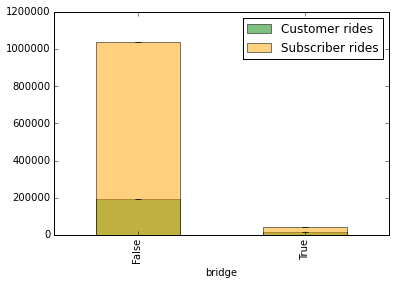

In [9]:
counts_c = df['bridge'][df.usertype == 'Customer'].groupby(df['bridge']).count()
error_c = np.sqrt(counts_c)
counts_s = df['bridge'][df.usertype == 'Subscriber'].groupby(df['bridge']).count()
error_s = np.sqrt(counts_s)

counts_c.plot(kind = 'bar', yerr = [error_c, error_c], color='green', alpha=0.5, label = 'Customer rides')
ax = counts_s.plot(kind = 'bar', yerr = [error_s, error_s], color='orange', alpha=0.5, label = 'Subscriber rides')
ax.legend()

We also want to see the proportions of rides, so we normalize with respect to the total counts for each `usertype`.

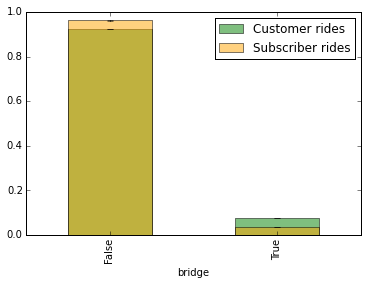

In [10]:
norm_c = counts_c.sum()
norm_s = counts_s.sum()

((counts_c)/norm_c).plot(kind = 'bar', yerr = [(error_c)/norm_c, (error_c)/norm_c], 
                         color='green', alpha=0.5, label = 'Customer rides')
ax = ((counts_s)/norm_s).plot(kind = 'bar', yerr = [(error_s)/norm_s, (error_s)/norm_s], 
                              color='orange', alpha=0.5, label = 'Subscriber rides')
ax.legend()

## $z$-test

Now, we calculate the relative proportions and errors for the terms we need to evaluate our null hypothesis, $\hat{p}_{C}$ and $\hat{p}_{S}$ (in the code, this is `bridge_c` and `bridge_s`.)

0.0765800282713 0.923419971729 0.000603722692549 0.00209642519642
0.0382792758746 0.961720724125 0.000188300740541 0.00094383191484
0.0765800282713 0.0382792758746 0.0445189148786 0.000491787429874 77.8807063177


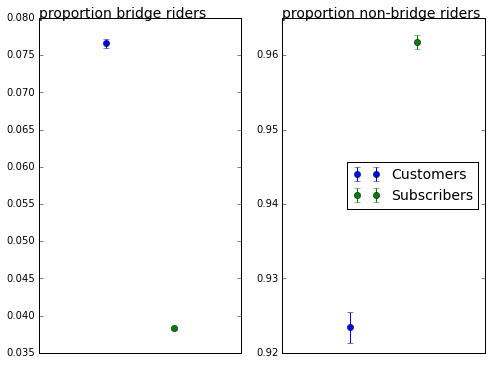

In [11]:
fig = pl.figure(figsize(8,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
bridge_c = counts_c[True]*1.0/norm_c
nobridge_c = counts_c[False]*1.0/norm_c
errbridge_c = error_c[True]*1.0/norm_c
errnobridge_c = error_c[False]*1.0/norm_c

bridge_s = counts_s[True]*1.0/norm_s
nobridge_s = counts_s[False]*1.0/norm_s
errbridge_s = error_s[True]*1.0/norm_s
errnobridge_s = error_s[False]*1.0/norm_s

print bridge_c, nobridge_c, errbridge_c, errnobridge_c
print bridge_s, nobridge_s, errbridge_s, errnobridge_s

ax1.errorbar([0.2],[bridge_c], yerr=[errbridge_c], fmt='o', label='Customers')
ax1.errorbar([0.4],[bridge_s], yerr=[errbridge_s], fmt='o', label='Subscribers')
ax1.text(0, 1, 'proportion bridge riders', transform = ax1.transAxes, size = 14)
ax1.set_xlim(0,0.6)
ax2.errorbar([0.2],[nobridge_c], yerr=[errnobridge_c], fmt='o', label='Customers')
ax2.errorbar([0.4],[nobridge_s], yerr=[errnobridge_s], fmt='o', label='Subscribers')
ax2.text(0, 1, 'proportion non-bridge riders', transform = ax2.transAxes, size = 14)
ax2.set_xlim(0,0.6)
pl.legend(loc='best', fontsize = 14)

p = (bridge_c*norm_c + bridge_s*norm_s)*1.0/ (norm_c + norm_s)
SE = np.sqrt(p * ( 1. - p ) * ( (1./norm_c) + (1./norm_s) ) )
z = (bridge_c - bridge_s ) / SE
print bridge_c, bridge_s, p,SE,z

What is the difference in proportions $\hat{p}_{C} - \hat{p}_{S}$?

In [12]:
Pc_Ps = bridge_c - bridge_s
print Pc_Ps

0.0383007523967


In [13]:
sp_stdev= lambda p0, n1: np.sqrt(p0*(1-p0)/n1)
sp_stdev_cs=sp_stdev(bridge_c,norm_s)

zscore = lambda p0, p1, s : (p0-p1)/s
z = zscore(bridge_c, bridge_s, sp_stdev_cs)
print z 

149.651040778


It is not necessary to check a table to determine that a value 149 standard deviations away has statistical significance! **Thus we reject the null hypothesis. If our assumptions hold, this implies that tourists *are* more likely to ride across the East River bridges than residents!** 

### $\chi^{2}$ test

Now let's use the $\chi^{2}$ test. To fill in the contingency table, we need to recall the counts for each of the four cells of the table:

In [14]:
print 'customers:\n', counts_c, '\n'*2, 'subscribers:\n', counts_s
print counts_c.product(), 194017*16090
print counts_c.sum(), counts_s.sum(), counts_c.sum()+counts_s.sum()

customers:
bridge
False    194017
True      16090
Name: bridge, dtype: int64 

subscribers:
bridge
False    1038266
True       41326
Name: bridge, dtype: int64
3121733530 3121733530
210107 1079592 1289699


| Rode across the bridge:   |     True   | False   |                   total
|---------------------------|----------------|------------------|---------------------------|
| Customers                 |  17797  |  203119    | 220996                       |
| Subscribers               |  35602  |  922446    | 958048                       |
|                           |                |                  |                           |
| total                     |  53399      |  1125565         | **1178964**         |

Now we calculate $\chi^{2}$ using the formula for a 2 $\times$ 2 contingency table:

In [15]:
Ntot = 1289699
expected = (16090+41326)*(194017+1038266)*210107*1079592*1.0
sample_values = [[16090,194017],[41326,1038266]]

chisqstat= lambda N, values, expect : ((values[0][0]*values[1][1]-values[0][1]*values[1][0])**2)/(expect)*N

print chisqstat(Ntot, sample_values, expected)

6065.40441654


This value is much, much larger than the $df = 1, \alpha = 0.05$ value of 3.84, so **we can (again) reject the null hypothesis.**

In [16]:
from scipy.stats import chi2_contingency
chi2_contingency([[counts_c[True], counts_c[False]],[counts_s[True],counts_s[False]]])[0]

6064.5040392673436